In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report)
import matplotlib.pyplot as plt

In [ ]:
!wget 'https://axe.inline-ltd.ru/data/meatinfo.csv' -O meatinfo.csv

--2023-08-30 18:58:50--  https://axe.inline-ltd.ru/data/meatinfo.csv
Resolving axe.inline-ltd.ru (axe.inline-ltd.ru)... 94.26.231.24
Connecting to axe.inline-ltd.ru (axe.inline-ltd.ru)|94.26.231.24|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://axe.inline-ltd.ru/data/meatinfo.csv [following]
--2023-08-30 18:58:51--  http://axe.inline-ltd.ru/data/meatinfo.csv
Connecting to axe.inline-ltd.ru (axe.inline-ltd.ru)|94.26.231.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4242855 (4.0M) [application/octet-stream]
Saving to: ‘meatinfo.csv’

meatinfo.csv        100%[===================>]   4.05M  3.89MB/s    in 1.0s    

2023-08-30 18:58:52 (3.89 MB/s) - ‘meatinfo.csv’ saved [4242855/4242855]



In [ ]:
df=pd.read_csv('meatinfo.csv', sep=';')
df

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина
...,...,...
17888,"Ягнятина, шея, бк",Ягнятина
17889,Язык ягненка (н.зеландия) Отварные языки ягнят...,Ягнятина
17890,"Ягнятина, язык, зачищ. цена 100 руб.",Ягнятина
17891,"Як, задние части, 1 категория цена 550 руб.",Як


Оставляем только виды продукции, для которых в датасете есть не менее 500 примеров

In [ ]:
counts = (df['mtype'].value_counts()>=500).to_frame()
counts.head(7)

,mtype
Говядина,True
Свинина,True
Кура,True
Индейка,True
Баранина,True
Цыпленок,True
Кролик,False


In [ ]:
indexes_list = counts[counts['mtype'] == True].index.tolist()
indexes_list

['Говядина', 'Свинина', 'Кура', 'Индейка', 'Баранина', 'Цыпленок']

In [ ]:
df_model = df[df['mtype'].isin(indexes_list)]
df_model

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина
...,...,...
17816,"Цыпленок, четвертина, задняя",Цыпленок
17817,"Цыпленок, четвертина, задняя цена 100 руб.",Цыпленок
17818,ЦБ Шеи п/ф Свеженка ГОСТ зам пак Шеи куриные П...,Цыпленок
17819,"Цыпленок, шея, без кожи",Цыпленок


In [ ]:
df_model['mtype'].value_counts().head(50), df['mtype'].value_counts().head(6)

(Говядина    8422
 Свинина     3050
 Кура        1571
 Индейка     1337
 Баранина    1116
 Цыпленок     942
 Name: mtype, dtype: int64,
 Говядина    8422
 Свинина     3050
 Кура        1571
 Индейка     1337
 Баранина    1116
 Цыпленок     942
 Name: mtype, dtype: int64)

Присвоение значений классов

In [ ]:
def assign_mclass(mtype):
    if mtype == 'Говядина':
        return 0
    elif mtype == 'Свинина':
        return 1
    elif mtype == 'Кура':
        return 2
    elif mtype == 'Индейка':
        return 3
    elif mtype == 'Баранина':
        return 4
    elif mtype == 'Цыпленок':
        return 5

df_model['mclass'] = df_model['mtype'].apply(assign_mclass)

df_model

<ipython-input-8-adeca091c563>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['mclass'] = df_model['mtype'].apply(assign_mclass)


,text,mtype,mclass
0,12 частей баранина 12 частей баранина,Баранина,4
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина,4
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина,4
3,"Баранина, 12 частей, охл.",Баранина,4
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина,4
...,...,...,...
17816,"Цыпленок, четвертина, задняя",Цыпленок,5
17817,"Цыпленок, четвертина, задняя цена 100 руб.",Цыпленок,5
17818,ЦБ Шеи п/ф Свеженка ГОСТ зам пак Шеи куриные П...,Цыпленок,5
17819,"Цыпленок, шея, без кожи",Цыпленок,5


Разделение датасета 80% / 20%

In [ ]:
X = df_model['text']
y = df_model['mclass']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=2)

Векторизация текста

In [ ]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Преобразование данных в тензоры

In [ ]:
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

Создание объекта TensorDataset для работы с данными

In [ ]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

Создание загрузчиков данных

In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Определение модели

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = X_train_vec.shape[1]
hidden_size = 128
num_classes = df_model['mclass'].nunique()
model = TextClassifier(input_size, hidden_size, num_classes)

Обучение модели

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Оценка точности на тренировочном наборе данных
    model.eval()
    total_train = 0
    correct_train = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    # Оценка точности на тестовом наборе данных
    model.eval()
    total_test = 0
    correct_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    accuracy_train = 100 * correct_train / total_train
    accuracy_test = 100 * correct_test / total_test
    print(f"Epoch {epoch+1}: Train Accuracy: {accuracy_train}%, Test Accuracy: {accuracy_test}%")

Epoch 1: Train Accuracy: 97.46768060836501%, Test Accuracy: 95.89416058394161%
Epoch 2: Train Accuracy: 98.1444866920152%, Test Accuracy: 95.68126520681265%
Epoch 3: Train Accuracy: 98.91254752851711%, Test Accuracy: 95.74209245742092%
Epoch 4: Train Accuracy: 99.1787072243346%, Test Accuracy: 95.89416058394161%
Epoch 5: Train Accuracy: 99.33079847908745%, Test Accuracy: 95.25547445255475%
Epoch 6: Train Accuracy: 99.47528517110266%, Test Accuracy: 95.28588807785889%
Epoch 7: Train Accuracy: 99.58174904942966%, Test Accuracy: 95.4683698296837%
Epoch 8: Train Accuracy: 99.66539923954373%, Test Accuracy: 95.52919708029196%
Epoch 9: Train Accuracy: 99.69581749049429%, Test Accuracy: 95.52919708029196%
Epoch 10: Train Accuracy: 99.787072243346%, Test Accuracy: 95.40754257907543%


Сохранение предсказанных меток классов

In [ ]:
model.eval()
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())

Визуализация матрицы ошибок

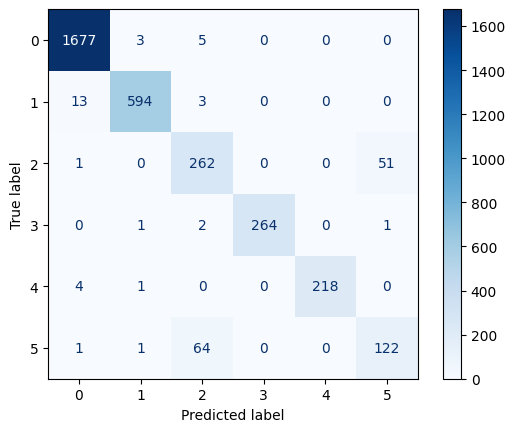

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted_labels)).plot(cmap=plt.cm.Blues)

Отчет о классификации.
Модель показывает хорошие результаты с точки зрения точности, полноты и F1-меры. Классы 2 и 5, имеют более низкие значения. Рекомендуется учитывать тот факт, что данные имеют неравномерное распределение по классам. В дальнейшем, стратегии OverSampling и UnderSampling могут помочь решить эту проблему.

In [ ]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1685
           1       0.99      0.97      0.98       610
           2       0.78      0.83      0.81       314
           3       1.00      0.99      0.99       268
           4       1.00      0.98      0.99       223
           5       0.70      0.65      0.67       188

    accuracy                           0.95      3288
   macro avg       0.91      0.90      0.91      3288
weighted avg       0.95      0.95      0.95      3288



Сохранение модели

In [ ]:
path = 'model.pt'
torch.save(model.state_dict(), path)

Применение модели к новому набору данных

In [ ]:
loaded_model = TextClassifier(input_size, hidden_size, num_classes)
loaded_model.load_state_dict(torch.load(path))
loaded_model.eval()

new_data = ["Говядина блочная 2 сорт в наличии ООО “АгроСоюз” реализует блочную говядину 2 сорт (80/20) Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.", "Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:", "Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем."]
new_data_vec = vectorizer.transform(new_data)
new_data_tensor = torch.tensor(new_data_vec.toarray(), dtype=torch.float32)

with torch.no_grad():
    outputs = loaded_model(new_data_tensor)

_, predicted_labels = torch.max(outputs, 1)

results = pd.DataFrame({'text': new_data, 'mclass': predicted_labels})
results

,text,mclass
0,Говядина блочная 2 сорт в наличии ООО “АгроСою...,0
1,Куриная разделка Продам кур и куриную разделку...,2
2,Говяжью мукозу Продам говяжью мукозу в охл и з...,0


Присвоение значений типов

In [ ]:
def assign_mtype(mclass):
    if mclass == 0:
        return 'Говядина'
    elif mclass == 1:
        return 'Свинина'
    elif mclass == 2:
        return 'Кура'
    elif mclass == 3:
        return 'Индейка'
    elif mclass == 4:
        return 'Баранина'
    elif mclass == 5:
        return 'Цыпленок'

results['mtype'] = results['mclass'].apply(assign_mtype)

results

,text,mclass,mtype
0,Говядина блочная 2 сорт в наличии ООО “АгроСою...,0,Говядина
1,Куриная разделка Продам кур и куриную разделку...,2,Кура
2,Говяжью мукозу Продам говяжью мукозу в охл и з...,0,Говядина


Сохранение результатов

In [ ]:
results_prepared = results[['text', 'mtype']]
path = 'results.csv'

results_prepared.to_csv(path, index=False)
results_prepared

,text,mtype
0,Говядина блочная 2 сорт в наличии ООО “АгроСою...,Говядина
1,Куриная разделка Продам кур и куриную разделку...,Кура
2,Говяжью мукозу Продам говяжью мукозу в охл и з...,Говядина
